In [25]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite, community


In [26]:
# 1. Charger le CSV et construire le biparti
df = pd.read_csv("../data/inventors_inventions.csv")
B = nx.Graph()
B.add_nodes_from(df['inventor'], bipartite=0)
B.add_nodes_from(df['invention'], bipartite=1)
B.add_edges_from(df[['inventor','invention']].itertuples(index=False, name=None))


In [27]:
# 2. Projection inventeur→inventeur
inventors = [n for n,d in B.nodes(data=True) if d['bipartite']==0]
G = bipartite.weighted_projected_graph(B, inventors)


In [28]:
# 3. Filtrer top 20 par degré
deg = dict(G.degree())
top20 = sorted(deg, key=deg.get, reverse=True)[:20]
G_sub = G.subgraph(top20).copy()

# 4. Détection communautés
comms = community.greedy_modularity_communities(G_sub, weight='weight')
comm_map = {}
for idx, com in enumerate(comms):
    for node in com:
        comm_map[node] = idx

# 5. Mapping QID→label pour inventeurs et inventions
inventor_label = dict(zip(df['inventor'], df['inventorLabel']))
invention_label = dict(zip(df['invention'], df['inventionLabel']))


In [29]:
# 6. Afficher les top 20 inventeurs et leurs inventions
print("Top 20 inventeurs et leurs inventions :")
for inv in top20:
    name = inventor_label.get(inv, inv.split('/')[-1])
    invts = list(B.neighbors(inv))
    invt_names = [invention_label.get(i, i.split('/')[-1]) for i in invts]
    print(f" - {name} ({deg[inv]} connexions) → {', '.join(invt_names)}")


Top 20 inventeurs et leurs inventions :
 - Andrey Petrov (4 connexions) → AO "Letno-issledovatel'skii institut imeni M. M. Gromova", 1941-2021. Istoriia LII v litsakh, Letno-Issledovatelʹskij Institut Imeni M. M. Gromova, 1941-2001 : sobytija, ljudi ; [k 60-letiju LII Im. M. M. Gromova], Kommentariĭ k Vozdushnomu kodeksu Rossiĭskoĭ Federat︠s︡ii : ot 19 marta 1997 g. no. 60-FZ : postateĭnyĭ, Logistic support analysis : theory and practice, International Conference Aircraft Flight Safety : actual problems of aircraft development : 31 August - 5 September 1993 Zhukovsky, Russia, Effektivnost' tekhnicheskoi ekspluatatsii samoletov grazhdanskoi aviatsii, Ekspluatatsionno-tekhnicheskie kharakteristiki i obespechenie ekspluatatsii aviatsionnoĭ tekhniki, Tekhnologii integrirovannoi logisticheskoi podderzhki v protsessakh zhiznennogo tsikla aviatsionnoi tekhniki, Vozdushnyi kodeks Rossiiskoi Federatsii : predislovie i postateinyi nauchno-prakticheskii kommentarii k Vozdushnomu kodeksu RF razrab

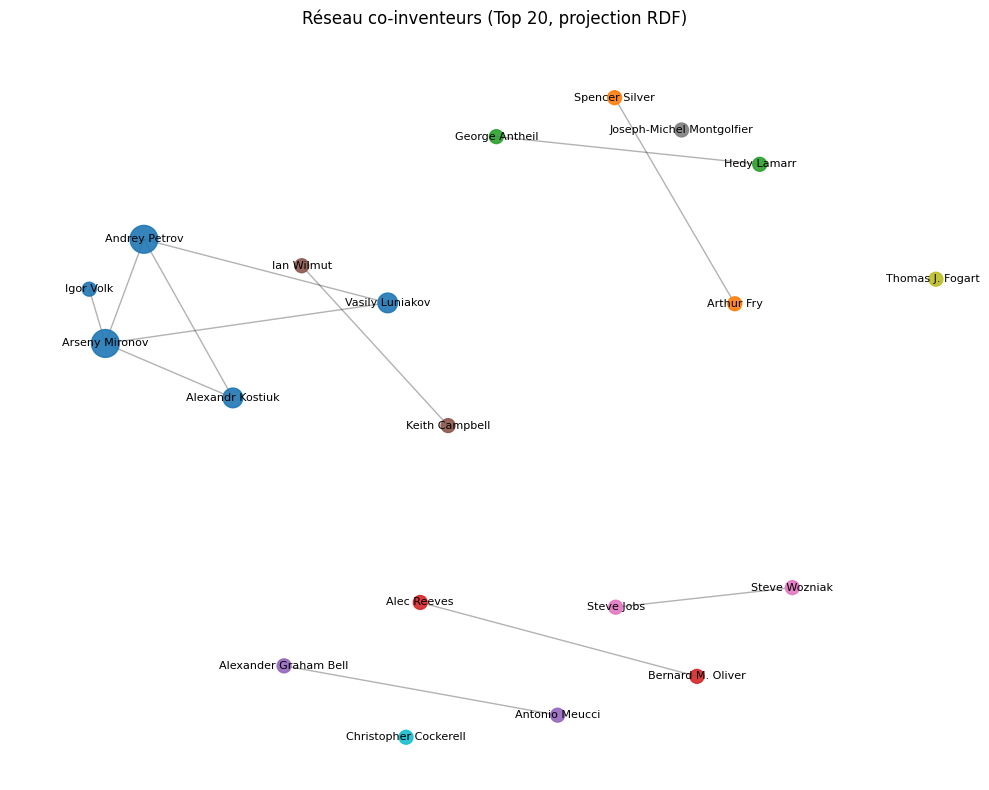

In [30]:
# 7. Visualisation 
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_sub, k=1, seed=42)

nx.draw_networkx_nodes(
    G_sub, pos,
    node_size=[deg[n]*100 for n in G_sub],
    node_color=[comm_map[n] for n in G_sub],
    cmap=plt.cm.tab10,
    alpha=0.9
)
nx.draw_networkx_edges(G_sub, pos, width=1, alpha=0.3)
nx.draw_networkx_labels(
    G_sub, pos,
    {n: inventor_label.get(n, n.split('/')[-1]) for n in G_sub},
    font_size=8
)

plt.title("Réseau co-inventeurs (Top 20, projection RDF)")
plt.axis('off')
plt.tight_layout()
plt.show()
